# 0.0. IMPORTS

In [69]:
import math 
import inflection
import random 
import pickle 
import requests
import warnings

import pandas                             as pd 
import numpy                              as np
import seaborn                            as sns 
import xgboost                            as xgb
 
from matplotlib             import pyplot as plt 
from IPython.core.display   import HTML
from IPython.display        import Image
from scipy                  import stats  as ss
from boruta                 import BorutaPy
from tabulate               import tabulate

from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model   import LinearRegression, Lasso
from sklearn.ensemble       import RandomForestRegressor
from sklearn.metrics        import mean_absolute_error, mean_squared_error

## 0.1. Load Data

In [2]:
data_sales_raw = pd.read_csv('data/train.csv')
data_store_raw = pd.read_csv('data/store.csv')

df_raw = pd.merge(data_sales_raw, data_store_raw, how = 'left', on ='Store')

C:\Users\bruni\AppData\Local\Temp\ipykernel_12968\2795723657.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data_sales_raw = pd.read_csv('data/train.csv')


## 0.2. Helper Functions

In [77]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

# 1.0. DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1 Rename columns 

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x : inflection.underscore(x)

new_cols = list(map(snakecase, old_cols))

df1.columns = new_cols

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [9]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4. Check NULL Data

In [12]:
df1.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NULL Data

### 1.5.1. competition_distance

In [13]:
print('Max : {}'.format(df1['competition_distance'].max()))
print('Min : {}'.format(df1['competition_distance'].min()))
df1.competition_distance.describe()

Max : 75860.0
Min : 20.0


count    1.014567e+06
mean     5.430086e+03
std      7.715324e+03
min      2.000000e+01
25%      7.100000e+02
50%      2.330000e+03
75%      6.890000e+03
max      7.586000e+04
Name: competition_distance, dtype: float64

In [14]:
df1['competition_distance'] = df1['competition_distance'].apply(
    lambda x : 200000.0 if np.isnan(x) else x
)

### 1.5.2. competition_open_since

In [15]:
df1['competition_open_since_month'] = df1.apply(
    lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else
    x['competition_open_since_month'], axis = 1)

In [16]:
df1['competition_open_since_year'] = df1.apply(
    lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else
    x['competition_open_since_year'], axis = 1)

### 1.5.3. promo

In [17]:
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(
x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

In [18]:
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(
x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

In [19]:
df1['promo_interval'].fillna(0, inplace = True)

C:\Users\bruni\AppData\Local\Temp\ipykernel_12968\108478887.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['promo_interval'].fillna(0, inplace = True)


### 1.5.4. Creating new columns

In [20]:
month_map = {1: 'Jan', 2: 'Feb', 3:'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['month_map'] = df1['date'].dt.month.map(month_map)

In [21]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( 
        lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] 
        in x['promo_interval'].split( ',' ) else 0, axis=1 )

## 1.6. Change Data Types

In [22]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [23]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

## 1.7. Descriptive Statistics

In [24]:
cat_attributes = df1.select_dtypes(exclude= ['int64', 'float64', 'int32', 'datetime64[ns]'])
num_attributes = df1.select_dtypes(include= ['int64', 'float64', 'int32'])

### 1.7.1. Numerical Attributes

In [25]:
mean_ = pd.DataFrame(num_attributes.apply(np.mean)).T
median_ = pd.DataFrame(num_attributes.apply(np.median)).T

std_ = pd.DataFrame( num_attributes.apply( np.std ) ).T
min_ = pd.DataFrame( num_attributes.apply( min ) ).T
max_ = pd.DataFrame( num_attributes.apply( max ) ).T
range_ = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
skew_ = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
kurtosis_ = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

description = pd.concat( [min_, max_, range_, mean_, median_, std_, skew_, kurtosis_] ).T.reset_index()
description.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

description

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Attributes

In [26]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

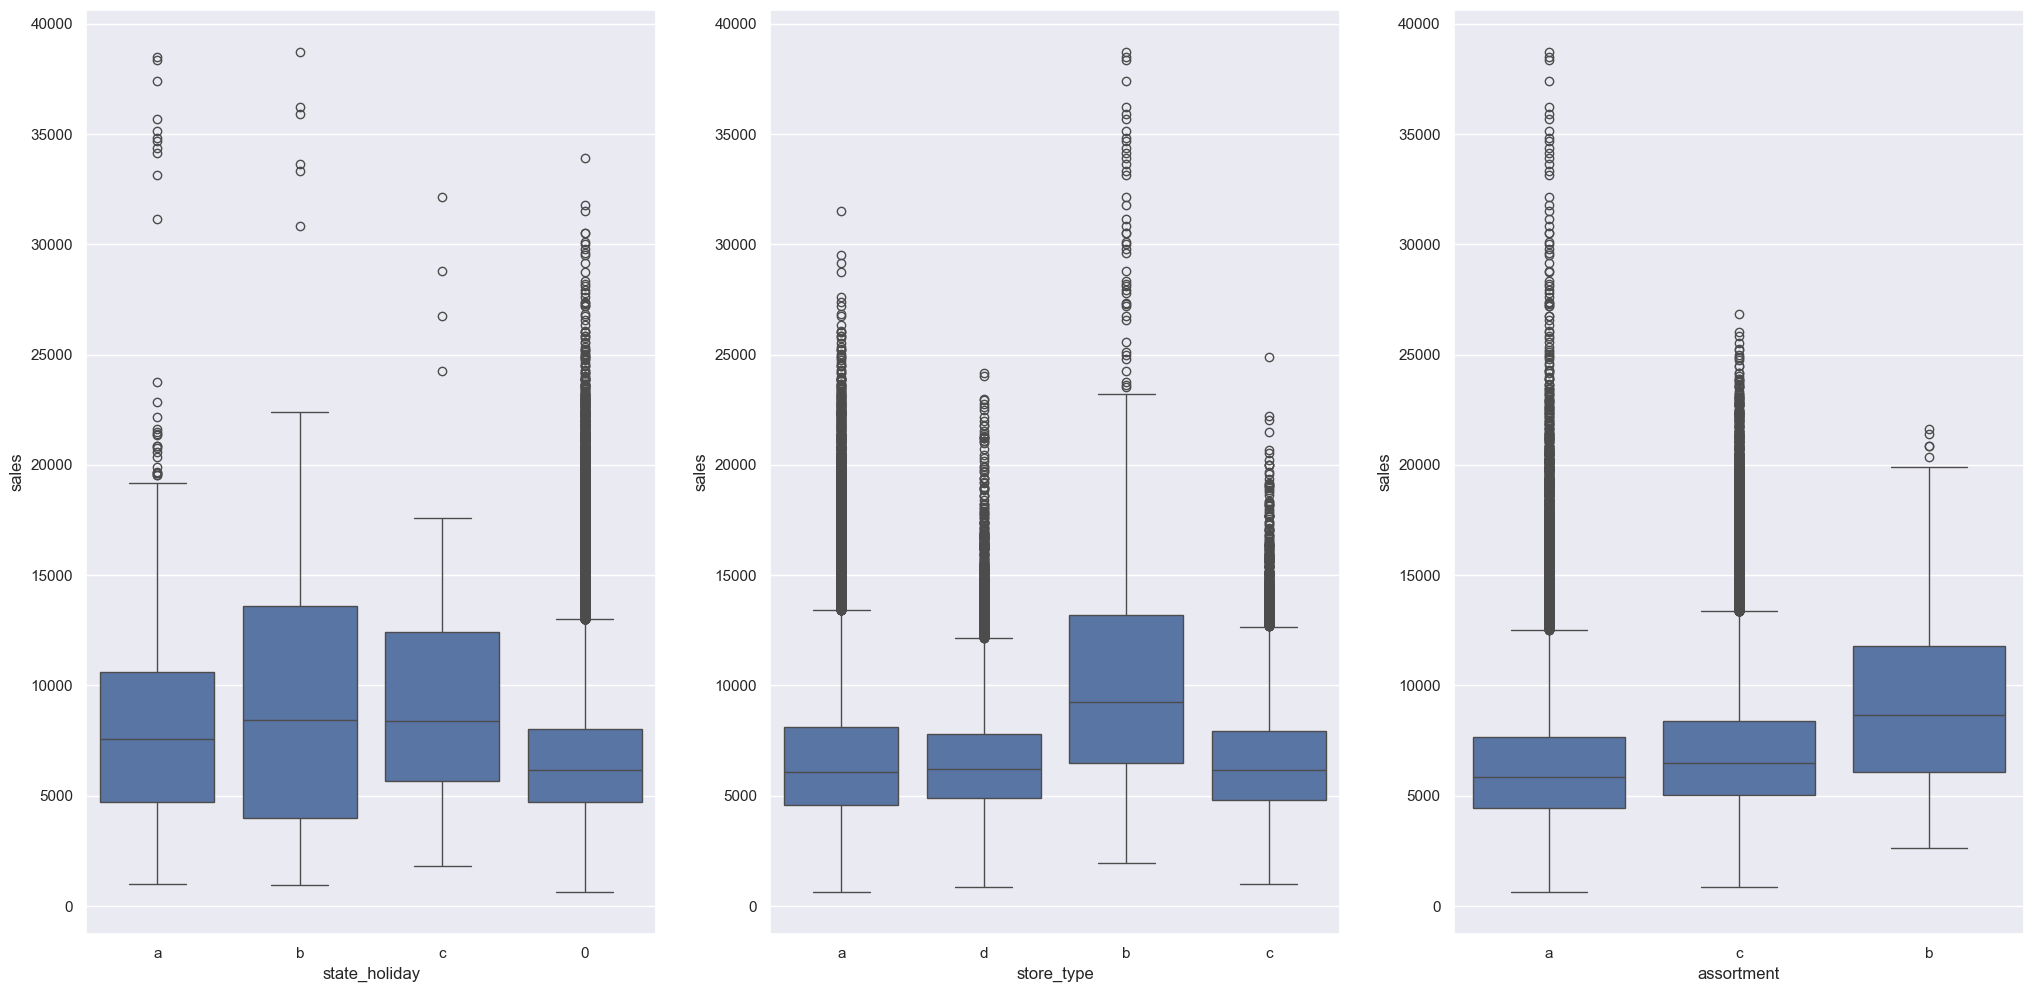

In [27]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0. FEATURE ENGINEERING

In [28]:
df2 = df1.copy()

## 2.2. Creation of Hypotheses

### 2.2.1. Store Hypotheses

1. Stores with more employees should sell more.

2. Stores with more stock should sell more.

3. Larger stores should sell more.

4. Stores with a larger assortment should sell more.

5. Stores with closer competitors should sell less.

6. Stores with longer competitors should sell more.

### 2.2.2. Product Hypotheses

1. Stores that invest more in marketing should sell more.

2. Stores with more product exposure should sell more.

3. Stores with lower-priced products should sell more.

4. Stores with more aggressive promotions (bigger discounts) should sell more.

5. Stores with longer promotions should sell more.

6. Stores with more promotion days should sell more.

7. Stores with more consecutive promotions should sell more.

### 2.2.3. Time Hypotheses

1. Stores open during the Christmas holidays should sell more.

2. Stores should sell more over the years.

3. Stores should sell more in the second half of the year.

4. Stores should sell more after the 10th of each month.

5. Stores should sell less at weekends.

6. Stores should sell less during school holidays


## 2.3. Final List of Hypotheses

1. Stores with a larger assortment should sell more.

2. Stores with closer competitors should sell less.

3. Stores with longer competitors should sell more.

4. Stores with active promotions for longer should sell more.

5. Stores with more promotion days should sell more.

7. Stores with more consecutive promotions should sell more.

8. Stores open during the Christmas holidays should sell more.

9. Stores should sell more over the years.

10. Stores should sell more in the second half of the year.

11. Stores should sell more after the 10th of each month.

12. Stores should sell less at weekends.

13. Stores should sell less during school holidays.

## 2.4. Feature Engineering

In [29]:
# Dates
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month
df2['day'] = df2['date'].dt.day
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

In [30]:
# Competition
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(
    year=x['competition_open_since_year'], month=x['competition_open_since_month'], 
    day=1), axis=1)

df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )
                                 /30).apply(lambda x: x.days).astype(int)

In [31]:
# Promo
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(
    lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'] )/7).apply(
    lambda x: x.days).astype(int)

In [32]:
# Assortment 
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a'
else 'extra' if x == 'b' else 'extended')

# State Holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x =='b' else 'christimas' if x == 'c' else 'regular_day')

In [33]:
df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,year_week,competition_since,competition_time_month,promo_since,promo_time_week
96645,756,3,2015-05-06,18820,2482,1,1,regular_day,0,a,extended,50.0,5,2015,1,40,2011,"Jan,Apr,Jul,Oct",May,0,2015,5,6,2015-18,2015-05-01,0,2011-09-26,188
698522,203,7,2013-10-13,0,0,0,0,regular_day,0,c,extended,490.0,11,2002,0,41,2013,0,Oct,0,2013,10,13,2013-40,2002-11-01,133,2013-10-07,0
195950,826,5,2015-02-06,10015,841,1,1,regular_day,0,a,extended,7980.0,6,2005,0,6,2015,0,Feb,0,2015,2,6,2015-05,2005-06-01,117,2015-02-02,0
868749,950,2,2013-05-14,8015,675,1,1,regular_day,0,a,basic,8460.0,11,1994,0,20,2013,0,May,0,2013,5,14,2013-19,1994-11-01,225,2013-05-13,0
937864,935,3,2013-03-13,4840,555,1,0,regular_day,0,a,extended,22350.0,6,2010,0,11,2013,0,Mar,0,2013,3,13,2013-10,2010-06-01,33,2013-03-11,0


# 3.0. VARIABLE FILTERING

In [34]:
df3 = df2.copy()

In [35]:
# Filtering Rows
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0 )]

# Filtering Cols
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

# 4.0. EXPLORATORY DATA ANALYSIS 

In [36]:
df4 = df3.copy()

## 4.1. Univariate Analysis 

### 4.1.1 Responde Variable

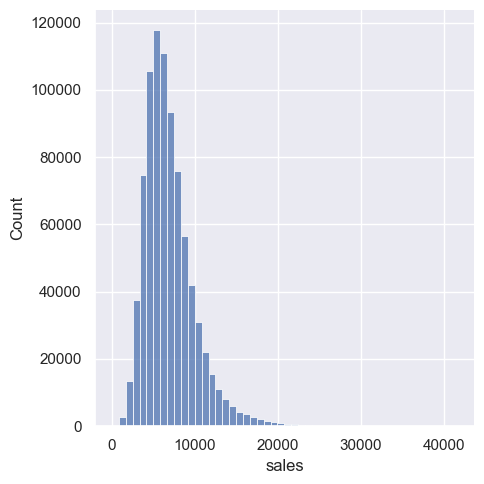

In [37]:
sns.displot(df4['sales'], kde=False, bins = 50)

### 4.1.2 Numerical Variable

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>],
       [<Axes: title={'center': 'customers'}>,
        <Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>],
       [<Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>,
        <Axes: title={'center': 'competition_open_since_month'}>],
       [<Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >]], dtype=object)

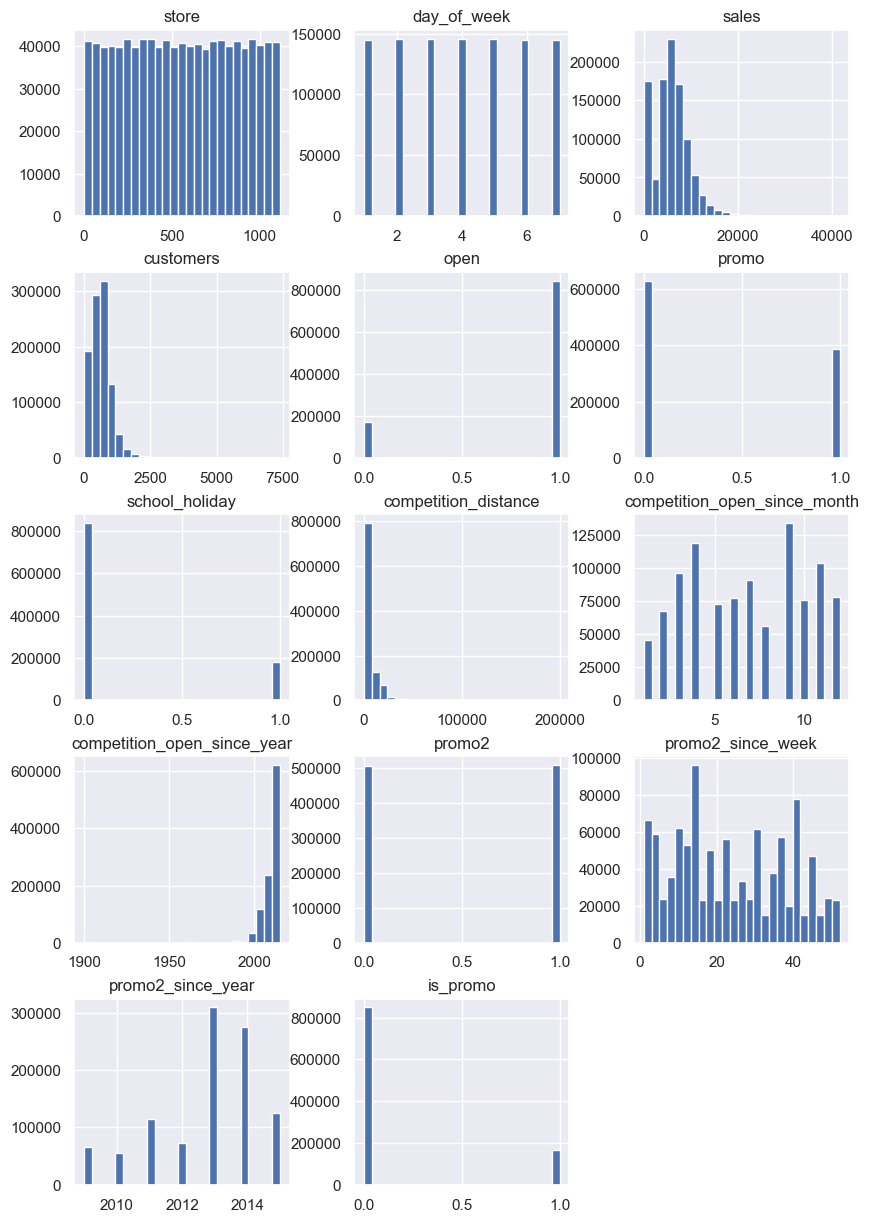

In [38]:
num_attributes.hist( bins=25, layout=(5,3), figsize=(10, 15))

### 4.1.3 Categorical Variable

In [39]:
df2['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christimas'],
      dtype=object)

C:\Users\bruni\AppData\Local\Temp\ipykernel_12968\1591240616.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
C:\Users\bruni\AppData\Local\Temp\ipykernel_12968\1591240616.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
C:\Users\bruni\AppData\Local\Temp\ipykernel_12968\1591240616.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
C:\Users\bruni\AppData\Local\Temp\ipykernel_12968\1591240616.py:8: FutureWarning: 

`shade` is

<Axes: xlabel='sales', ylabel='Density'>

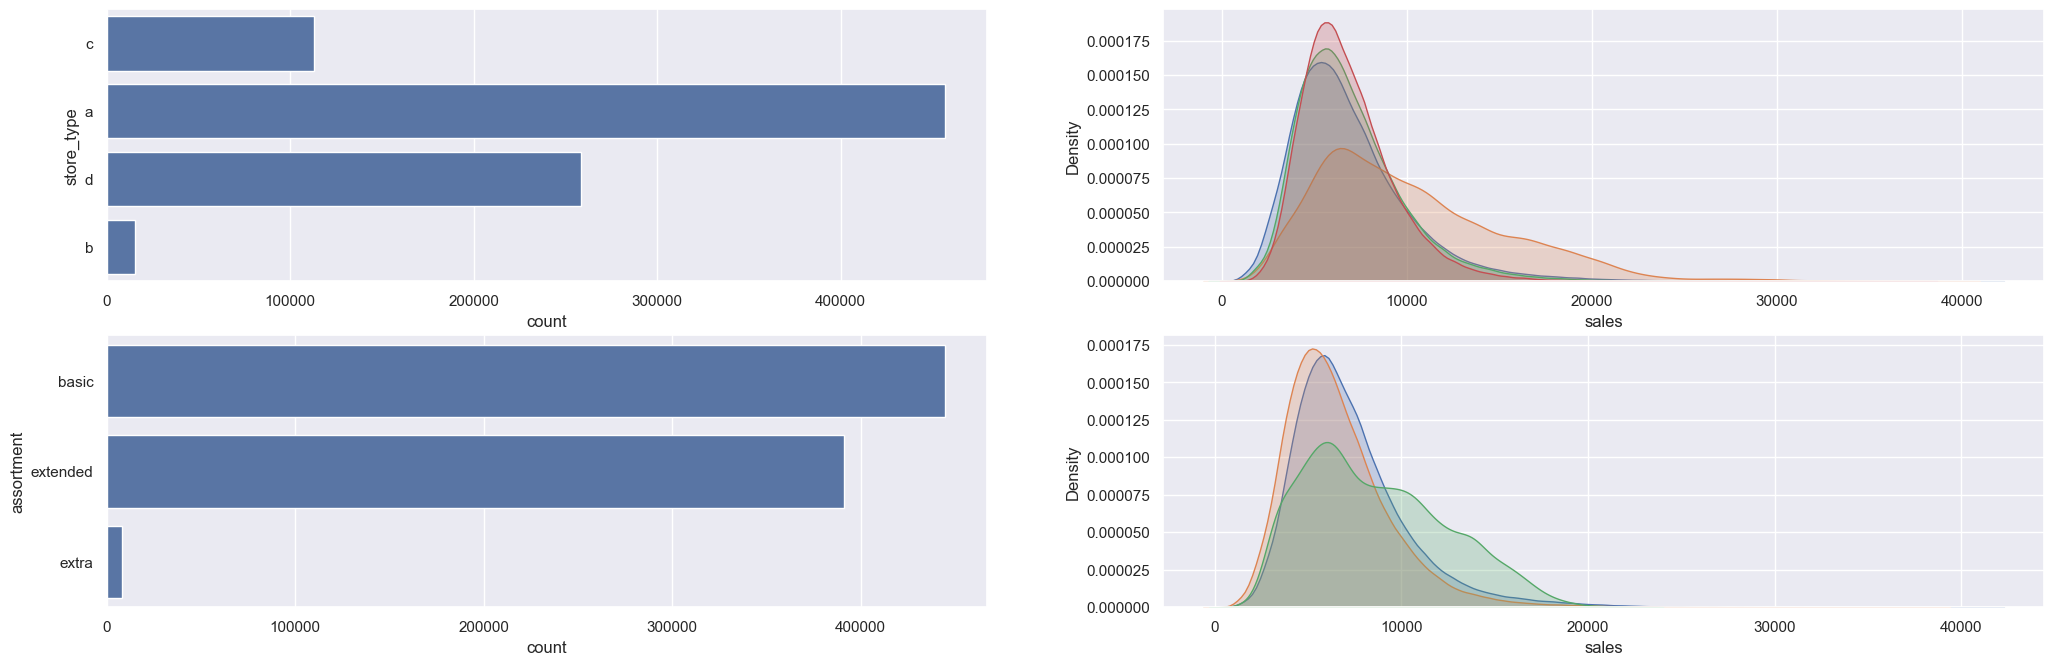

In [40]:
# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )
plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )
plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )


## 4.2. Bivariate Analysis

### H1. Stores with a larger assortment should sell more.

In [ ]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1)

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(
    ['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.plot( index = 'year_week', columns='assortment', values='sales').plot()

### H2. Stores with closer competitors should sell less.

C:\Users\bruni\AppData\Local\Temp\ipykernel_12968\2250560758.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_binned', 'sales']].groupby(


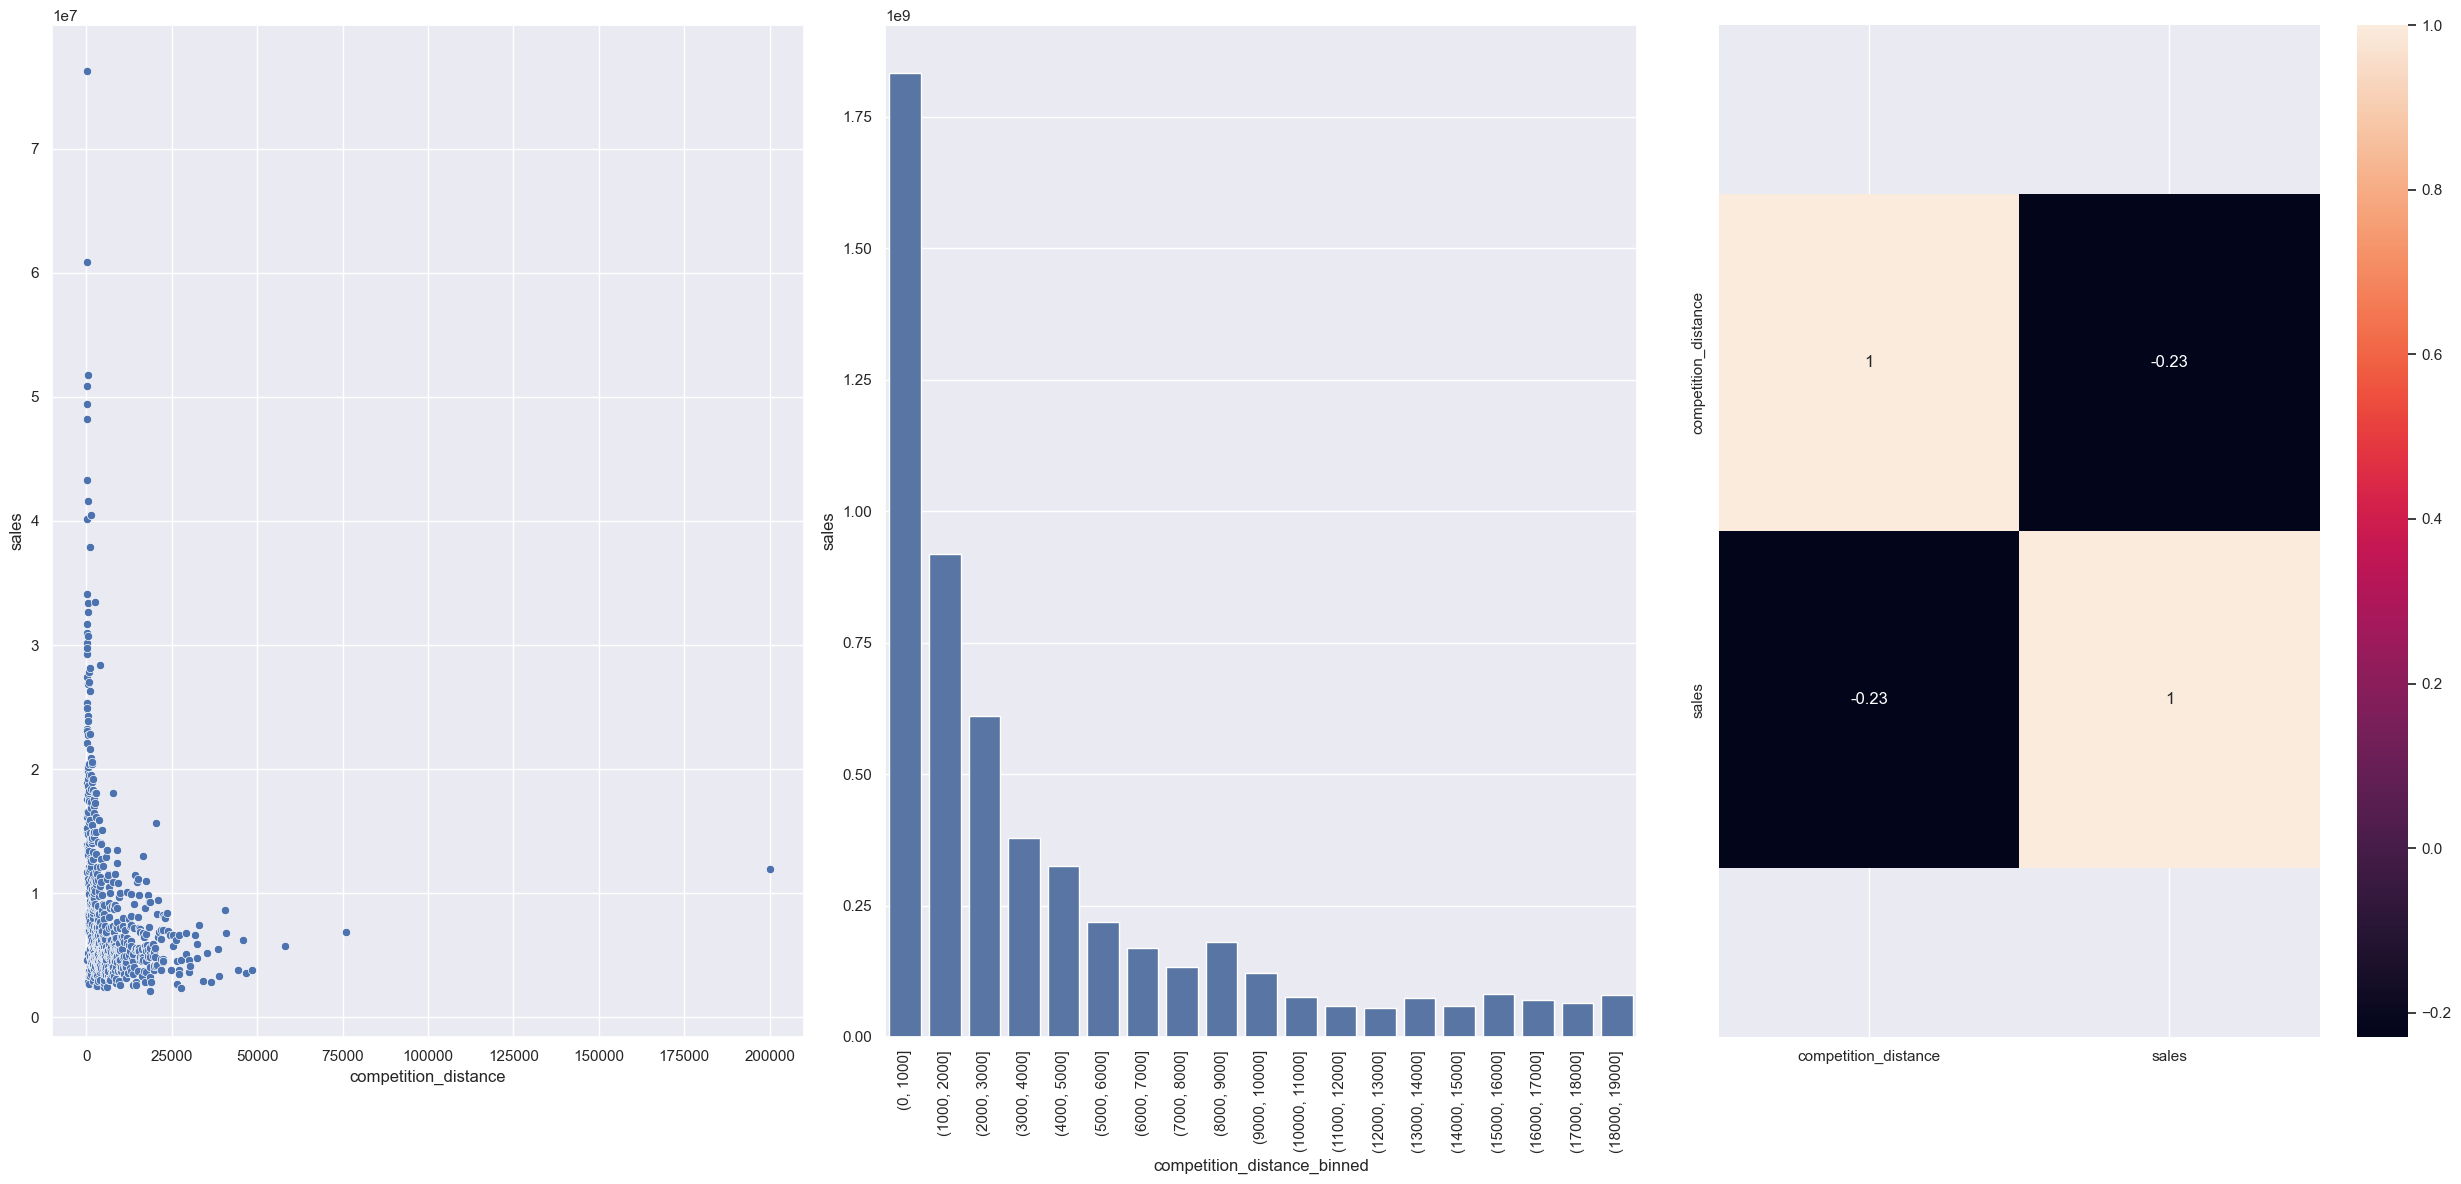

In [49]:
aux1 = df4[['competition_distance', 'sales']].groupby(
    'competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(
    aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby(
    'competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)

aux_corr = aux1.drop(columns=['competition_distance_binned'])
x = sns.heatmap(aux_corr.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5)

plt.tight_layout() 
plt.show()


### H3. Stores with longer competitors should sell more.

(2.5, -0.5)

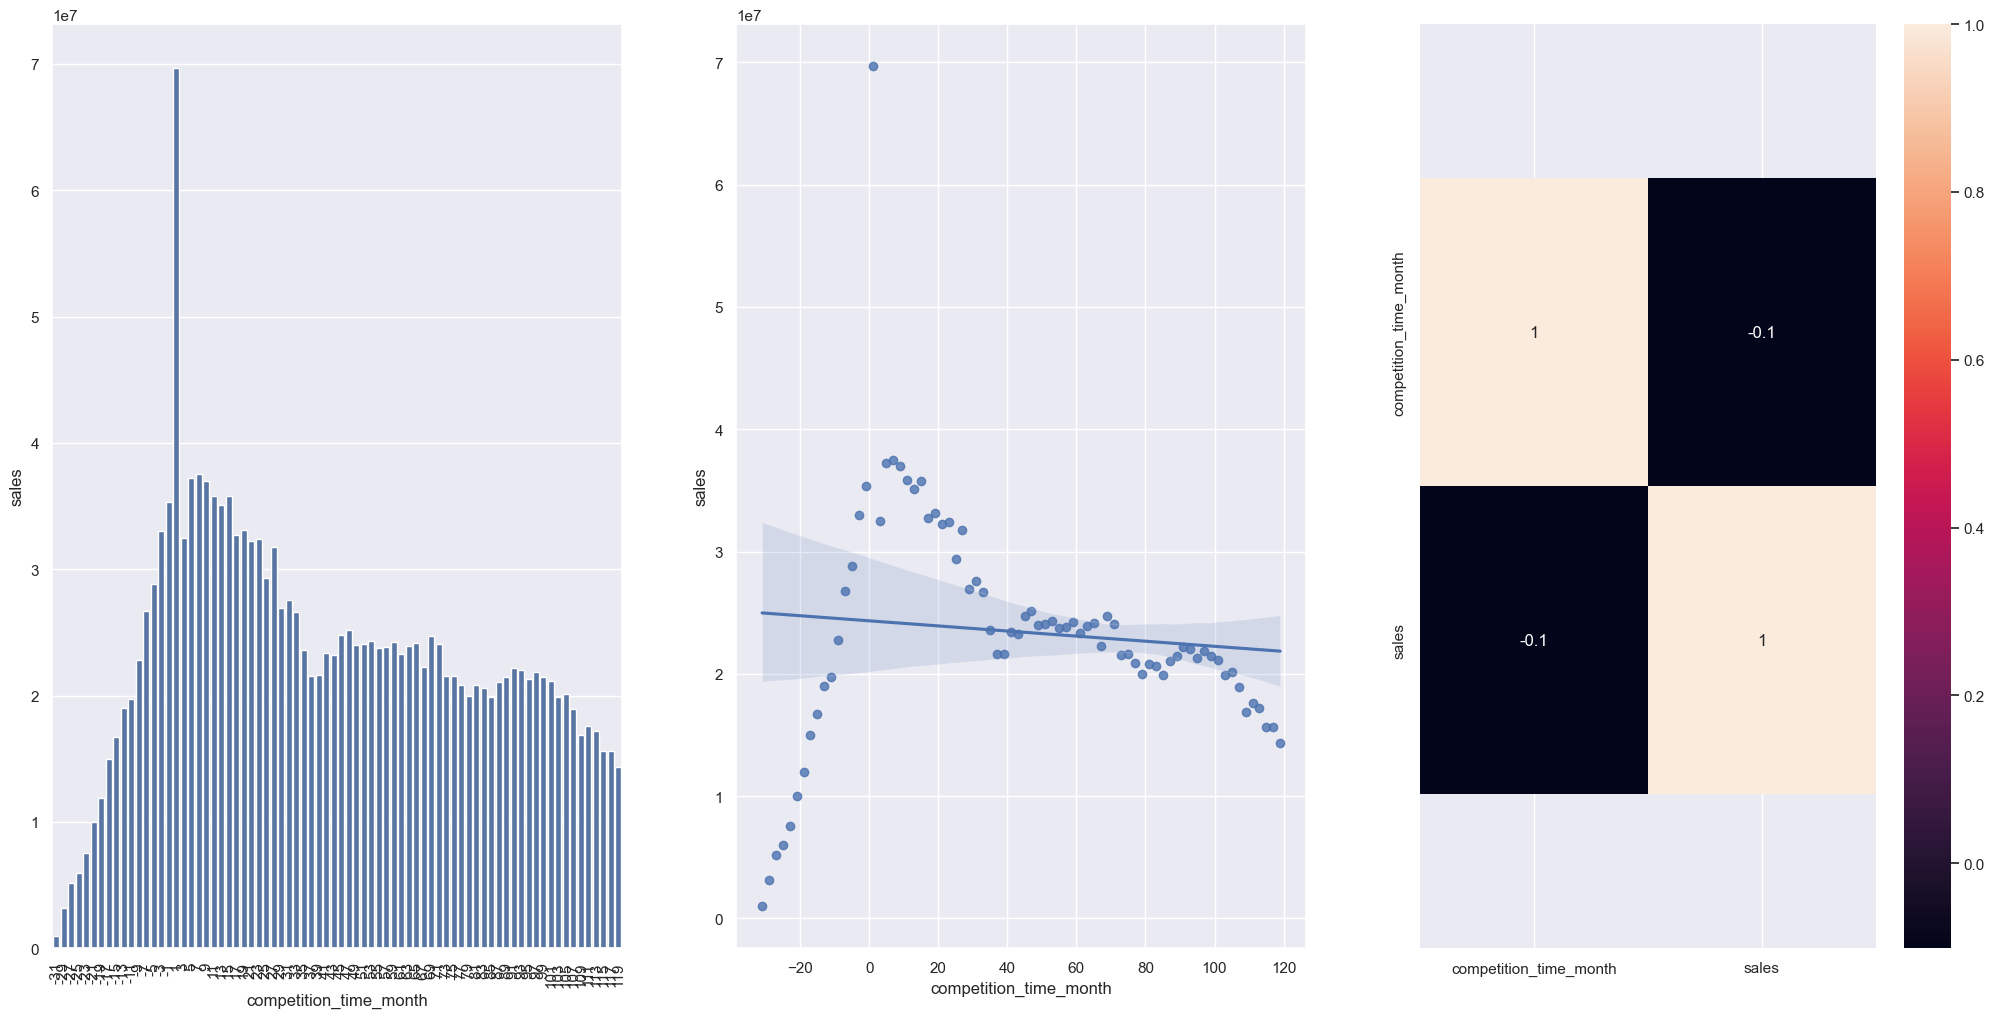

In [55]:
aux1  = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 )&
            aux1['competition_time_month'] != 0 ]
plt.subplot(1, 3, 1)
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2)
plt.xticks(rotation = 90)

plt.subplot(1,3,2)
sns.regplot(data=aux2, x = 'competition_time_month', y = 'sales')

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot = True)
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top -0.5)


### H4. Stores with active promotions for longer should sell more.

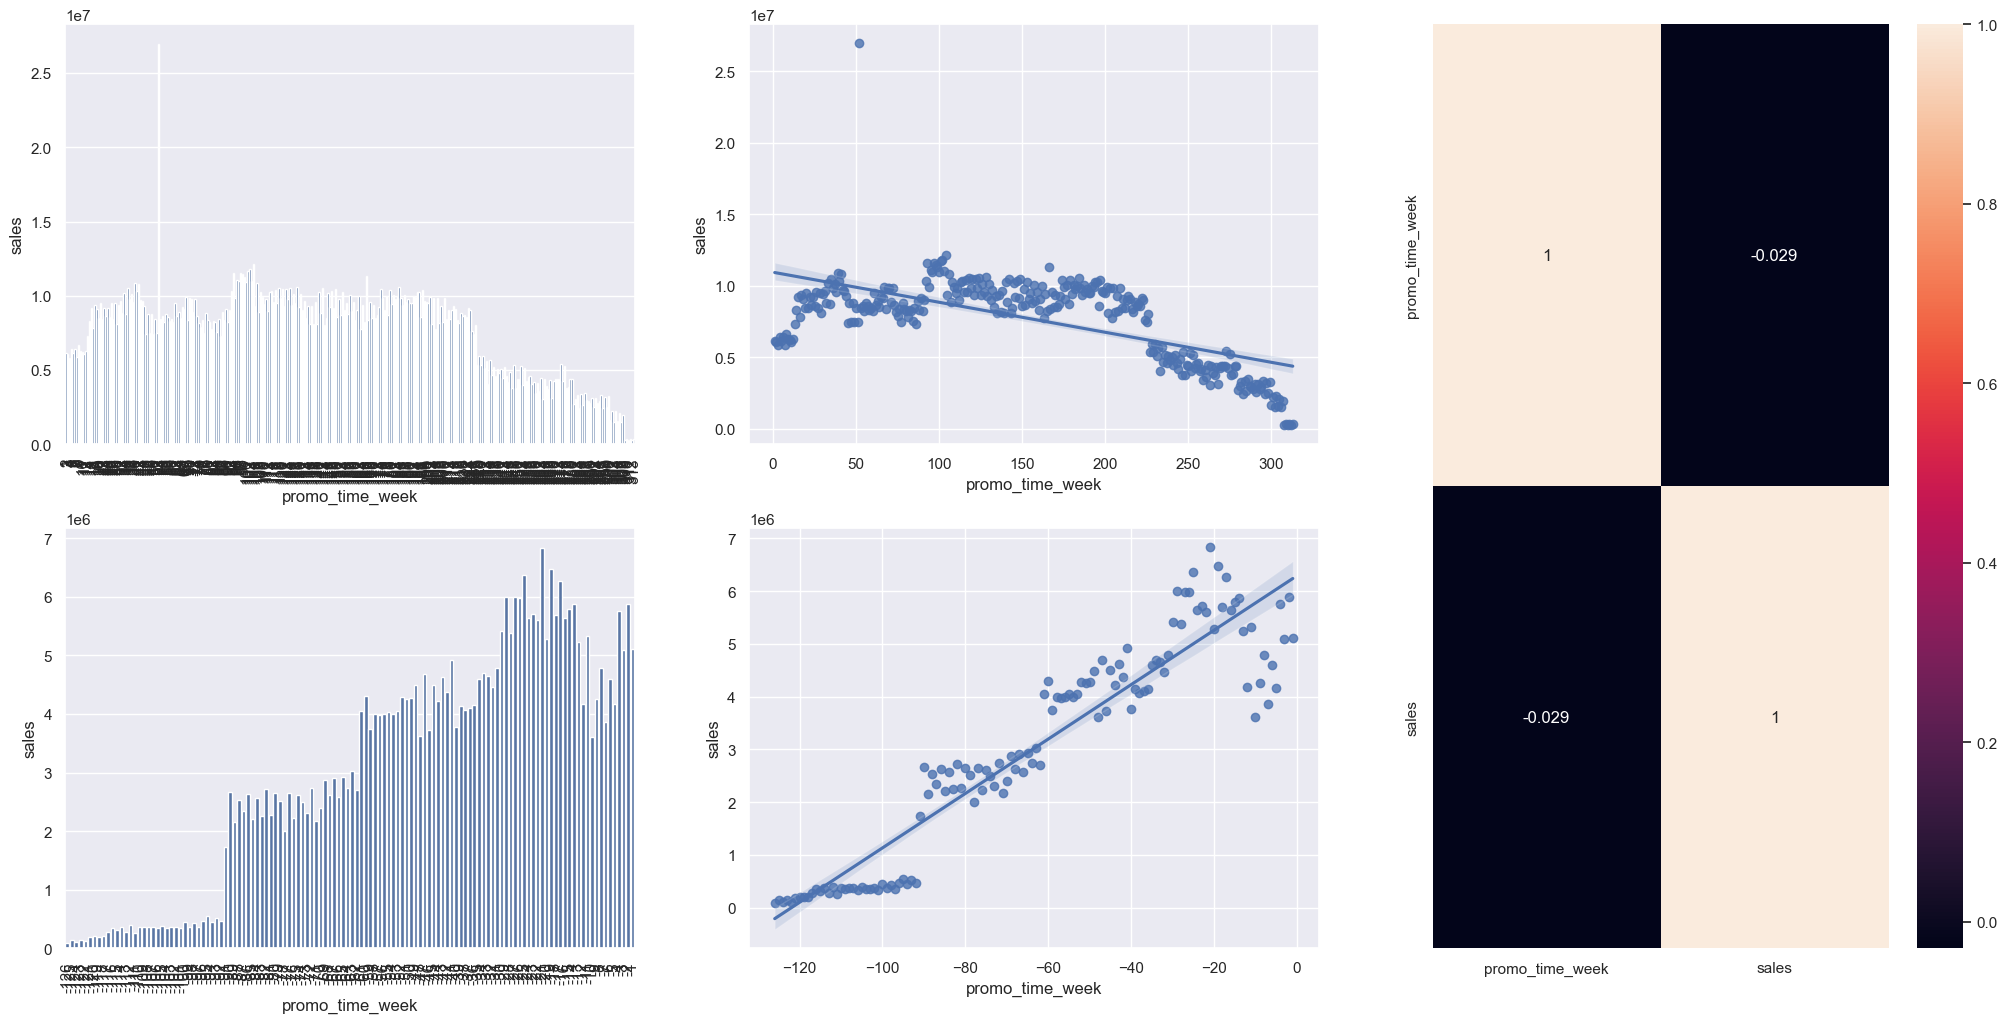

In [56]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()
grid = GridSpec( 2, 3 )
plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );
plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );
plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );
plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


### H5. Stores with more promotion days should sell more.

### H6. Stores with more consecutive promotions should sell more.

In [57]:
df4[['promo', 'promo2', 'sales']].groupby( 
    ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


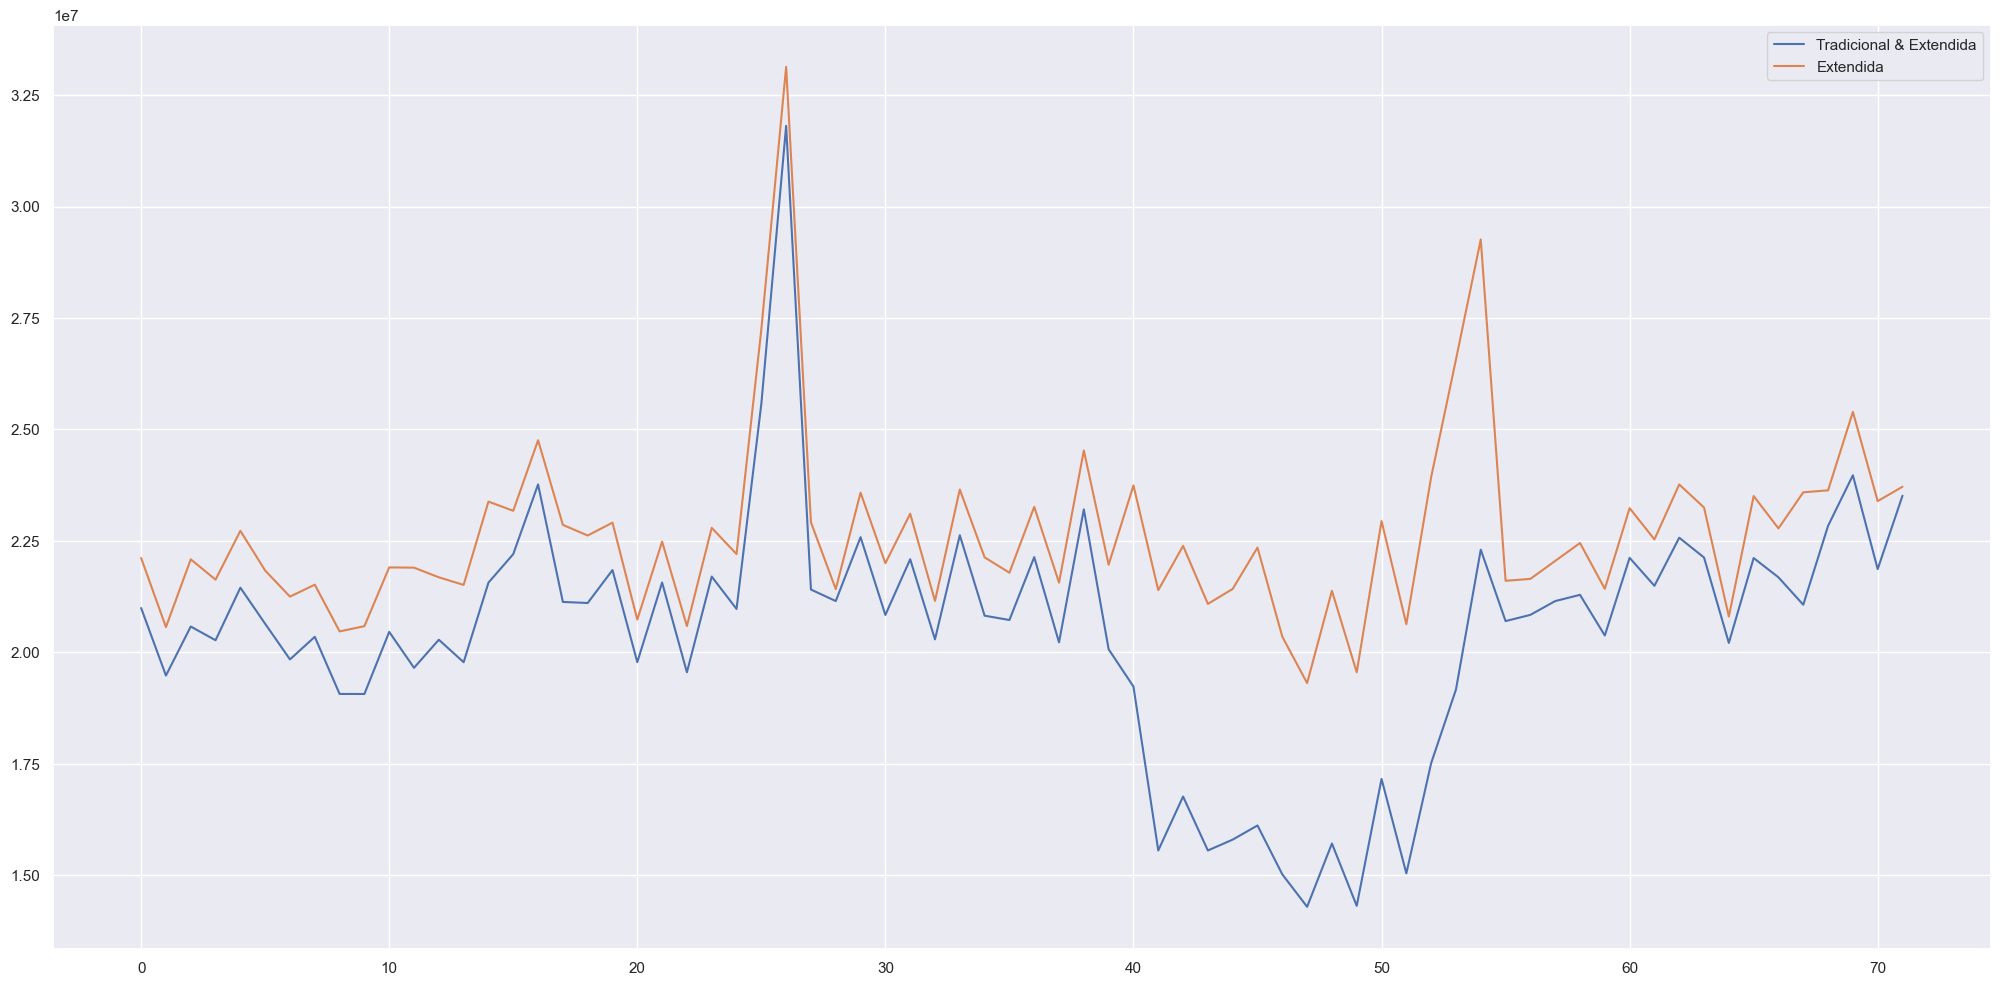

In [58]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )
           ][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )
           ][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )
ax.legend( labels=['Tradicional & Extendida', 'Extendida']);


### H7. Stores open during the Christmas holidays should sell more.

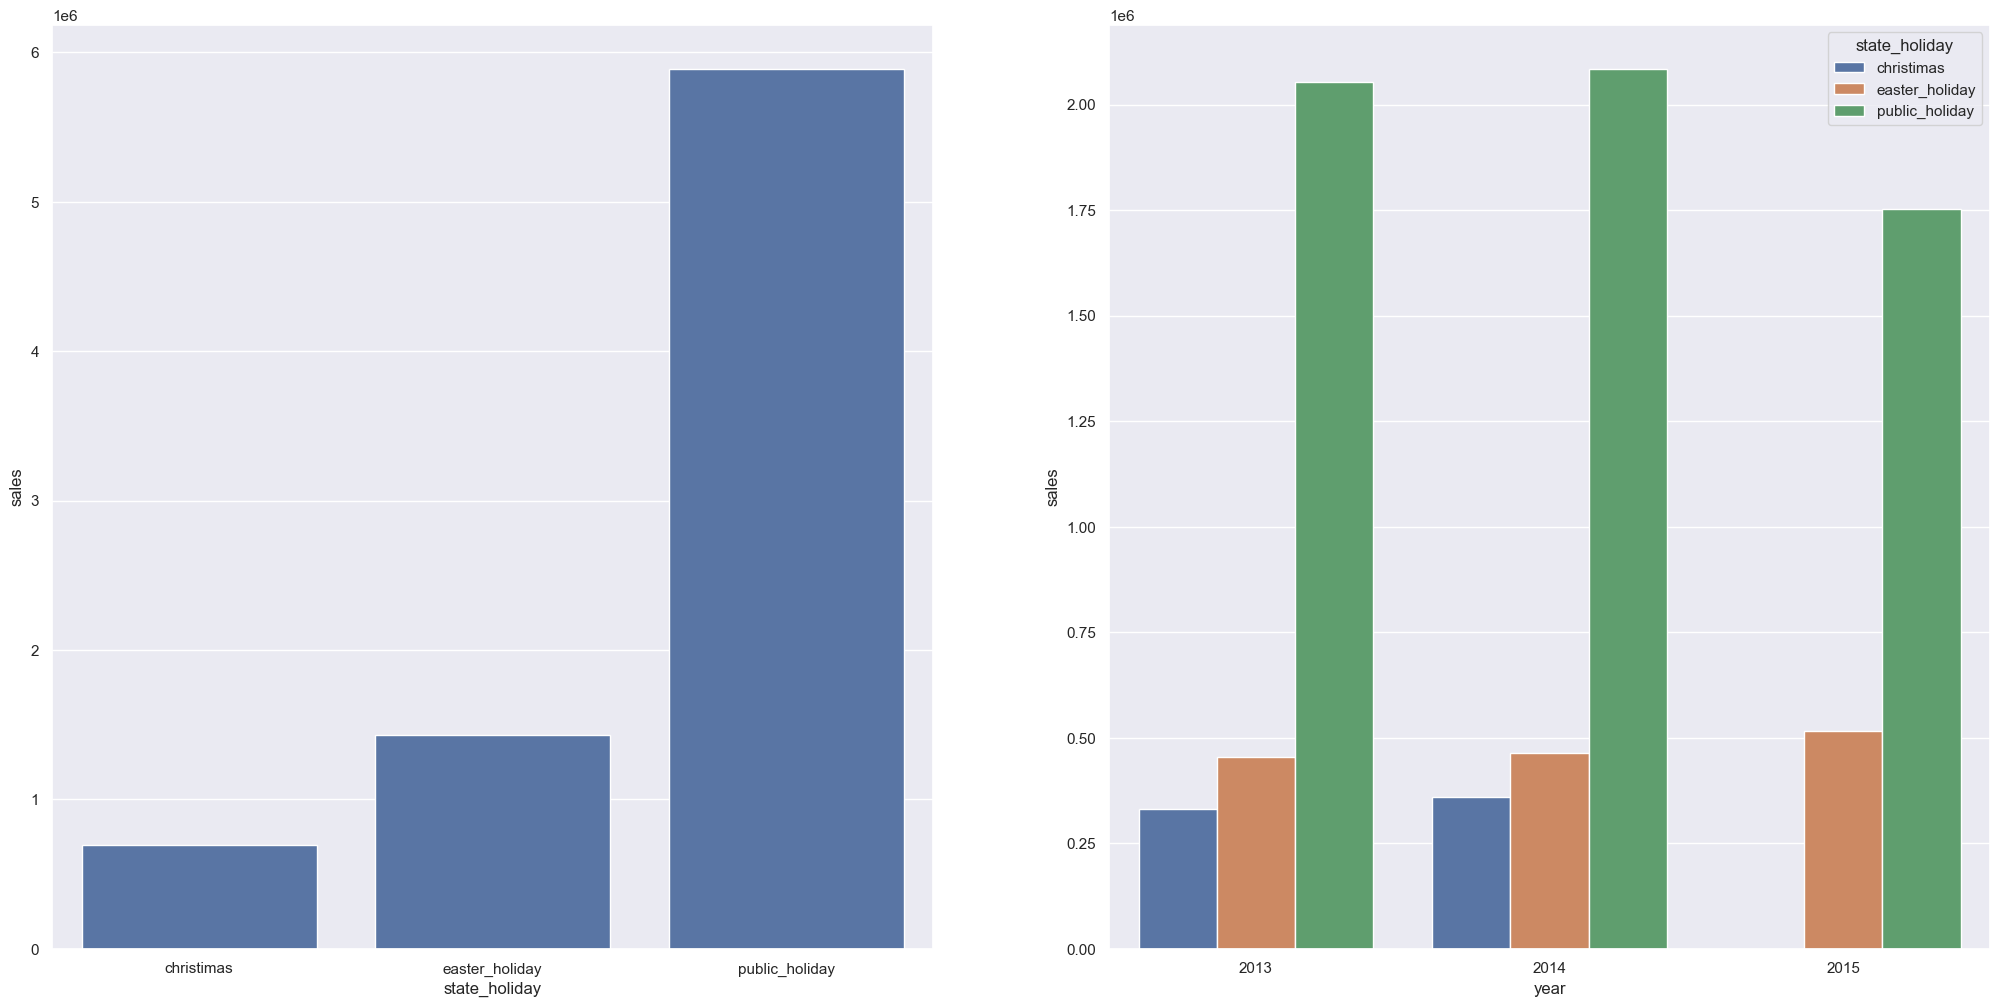

In [60]:
aux = df4[df4['state_holiday'] != 'regular_day']
plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby(
     'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );
plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']
           ].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### H8. Stores should sell more over the years.

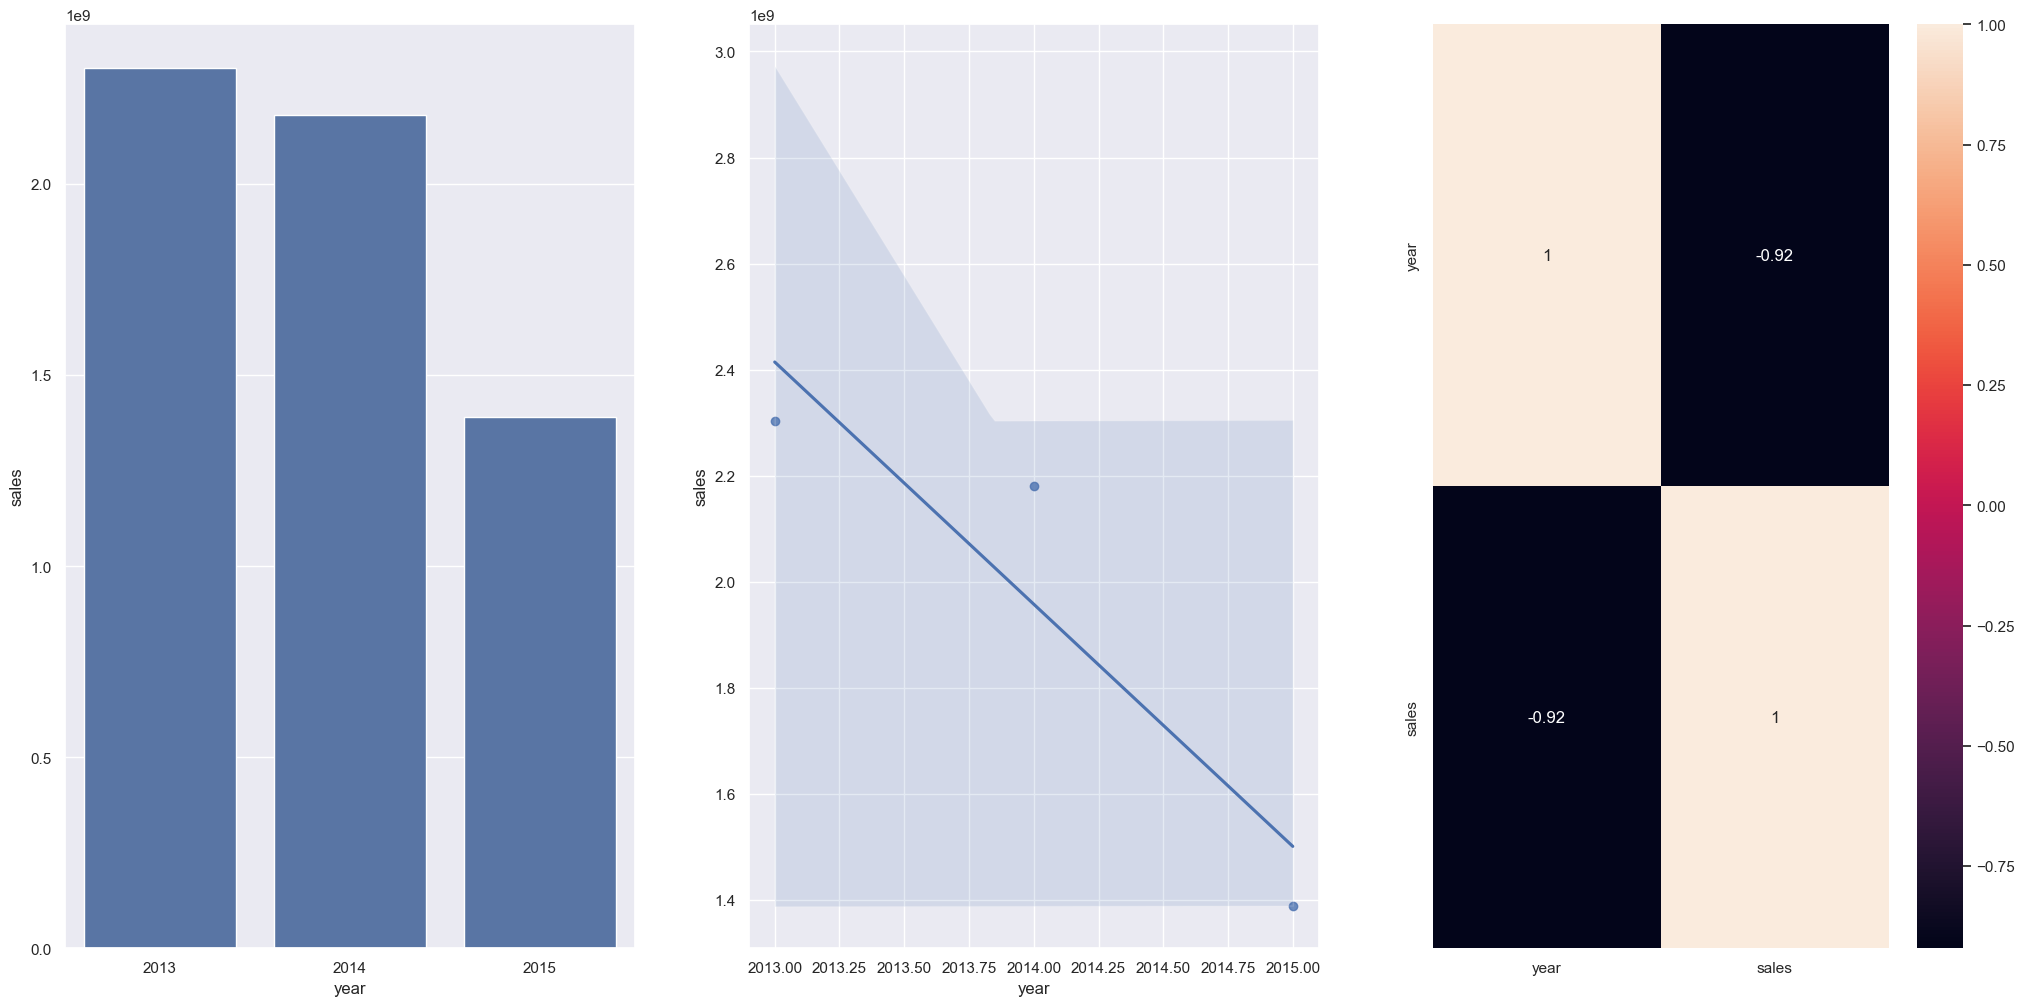

In [61]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H9. Stores should sell more in the second half of the year.

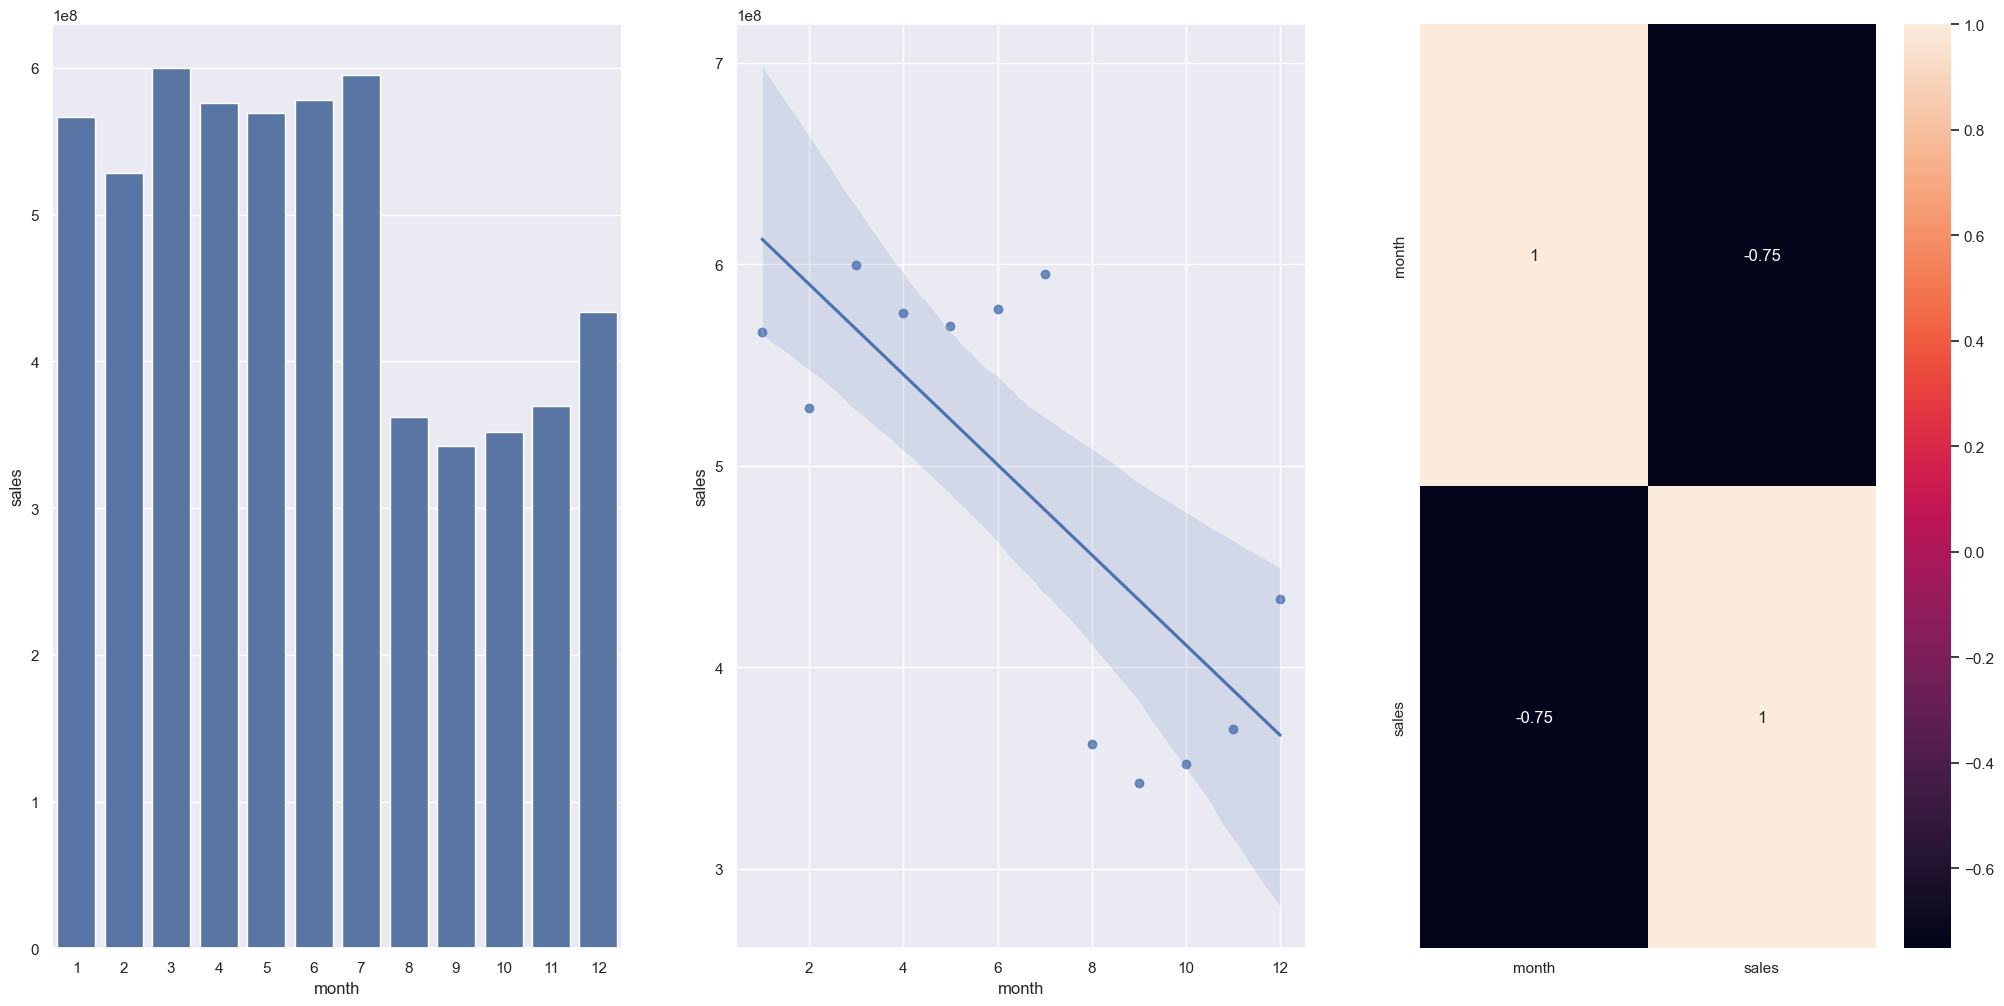

In [62]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H10. Stores should sell more after the 10th of each month.

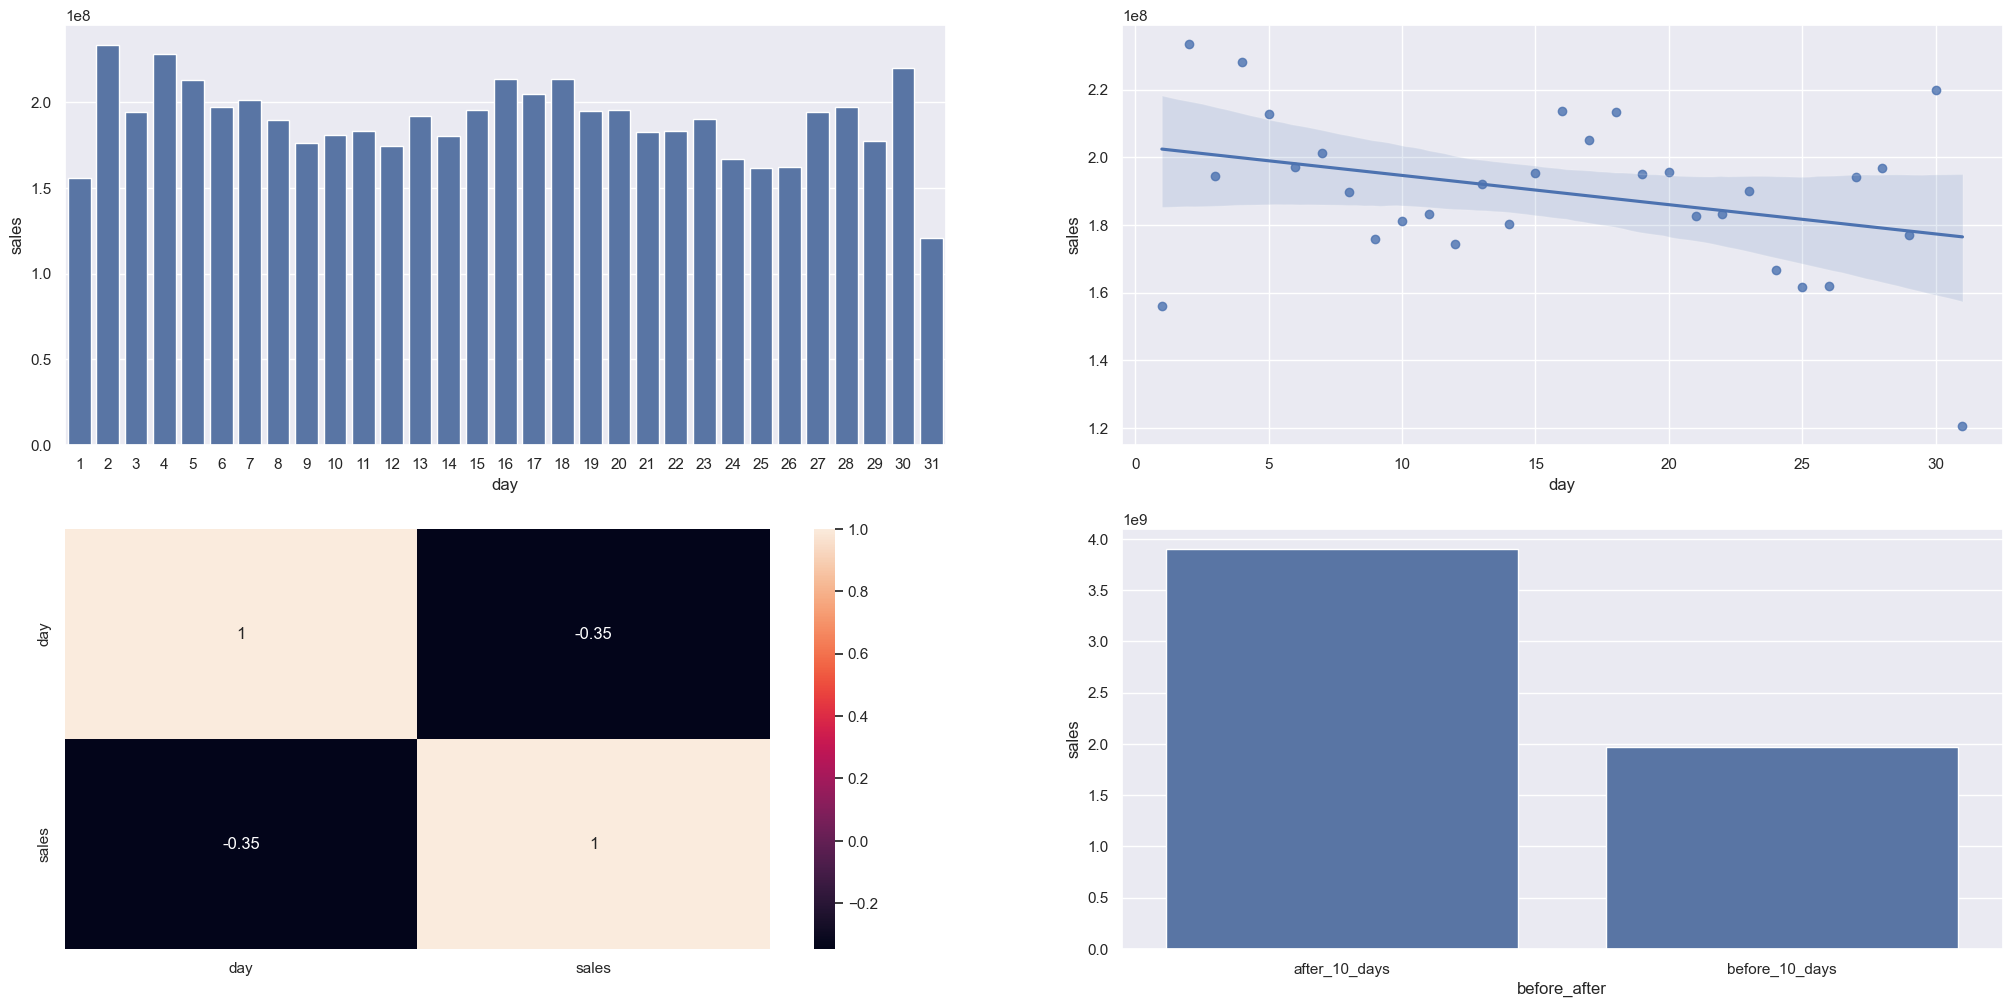

In [63]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()
plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );
plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );
plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
aux1['before_after'] = aux1['day'].apply( 
    lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']
           ].groupby( 'before_after' ).sum().reset_index()
plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );


### H11. Stores should sell less at weekends.

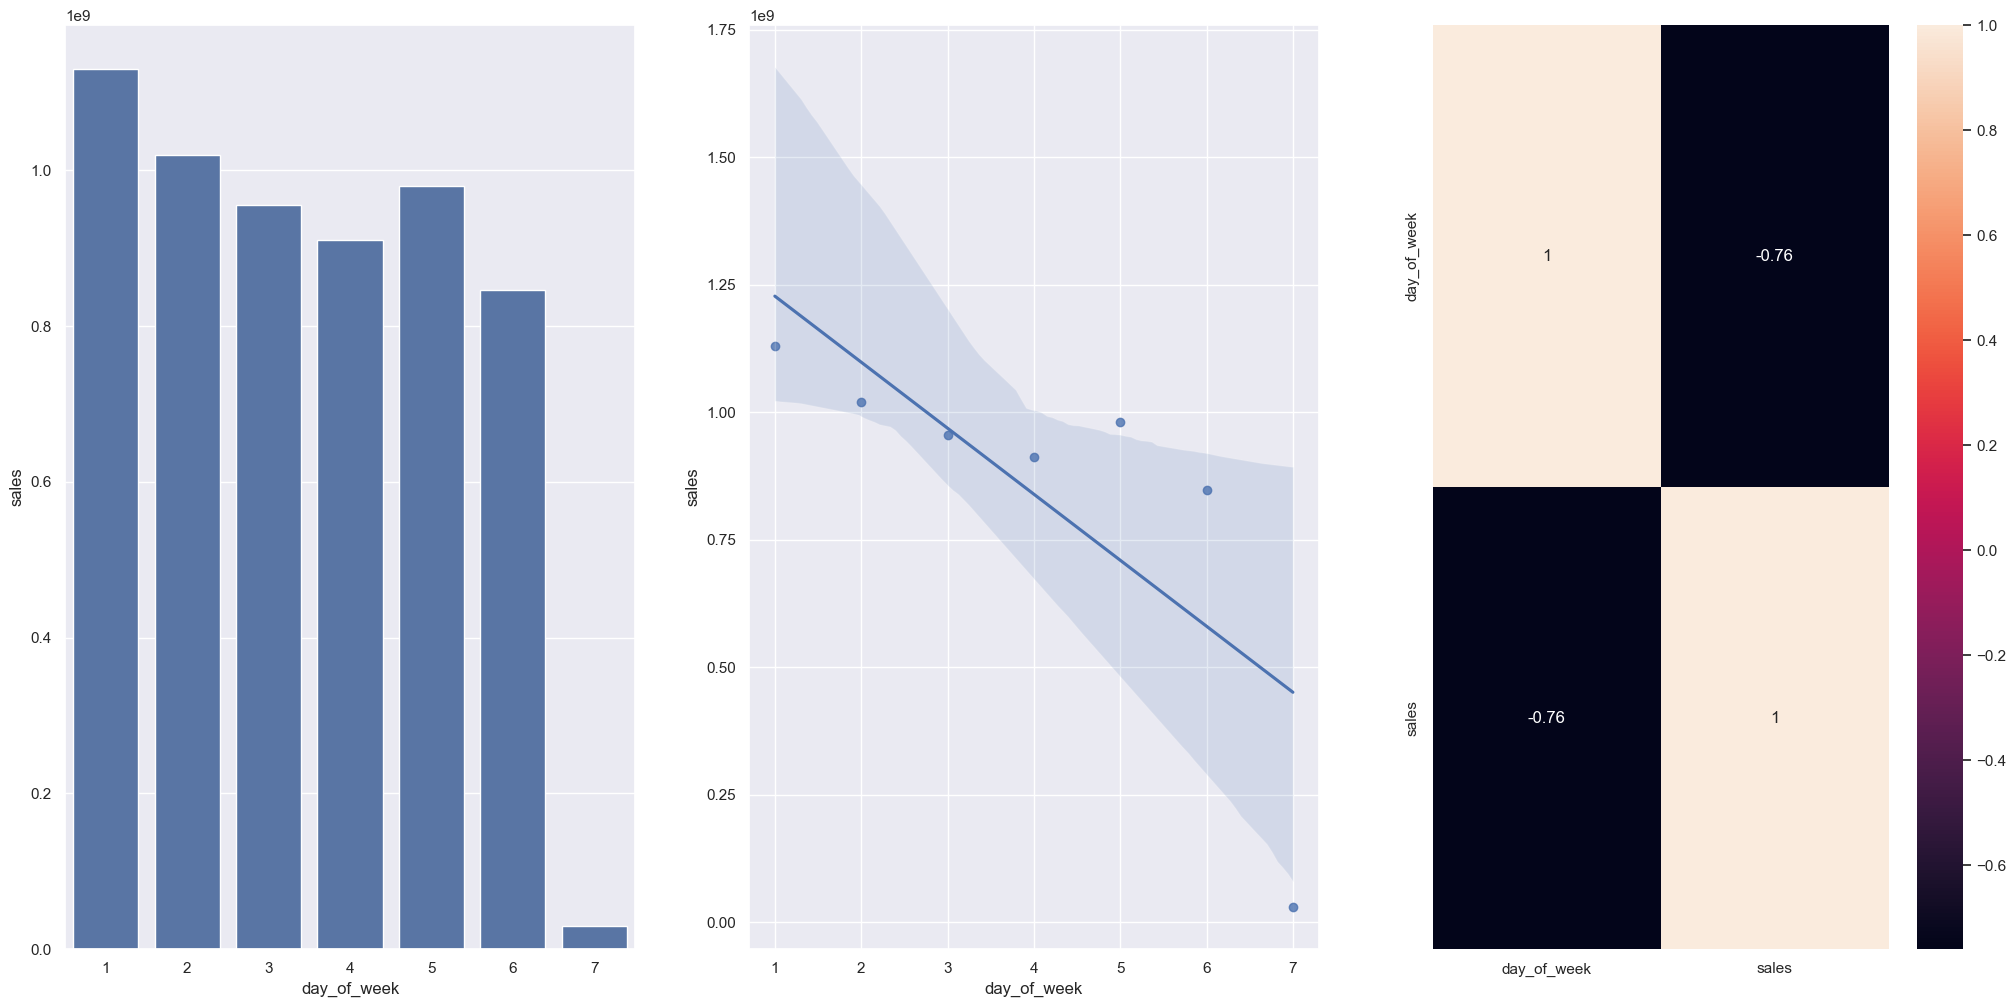

In [64]:
aux1 = df4[['day_of_week', 'sales']
            ].groupby( 'day_of_week' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H12. Stores should sell less during school holidays.

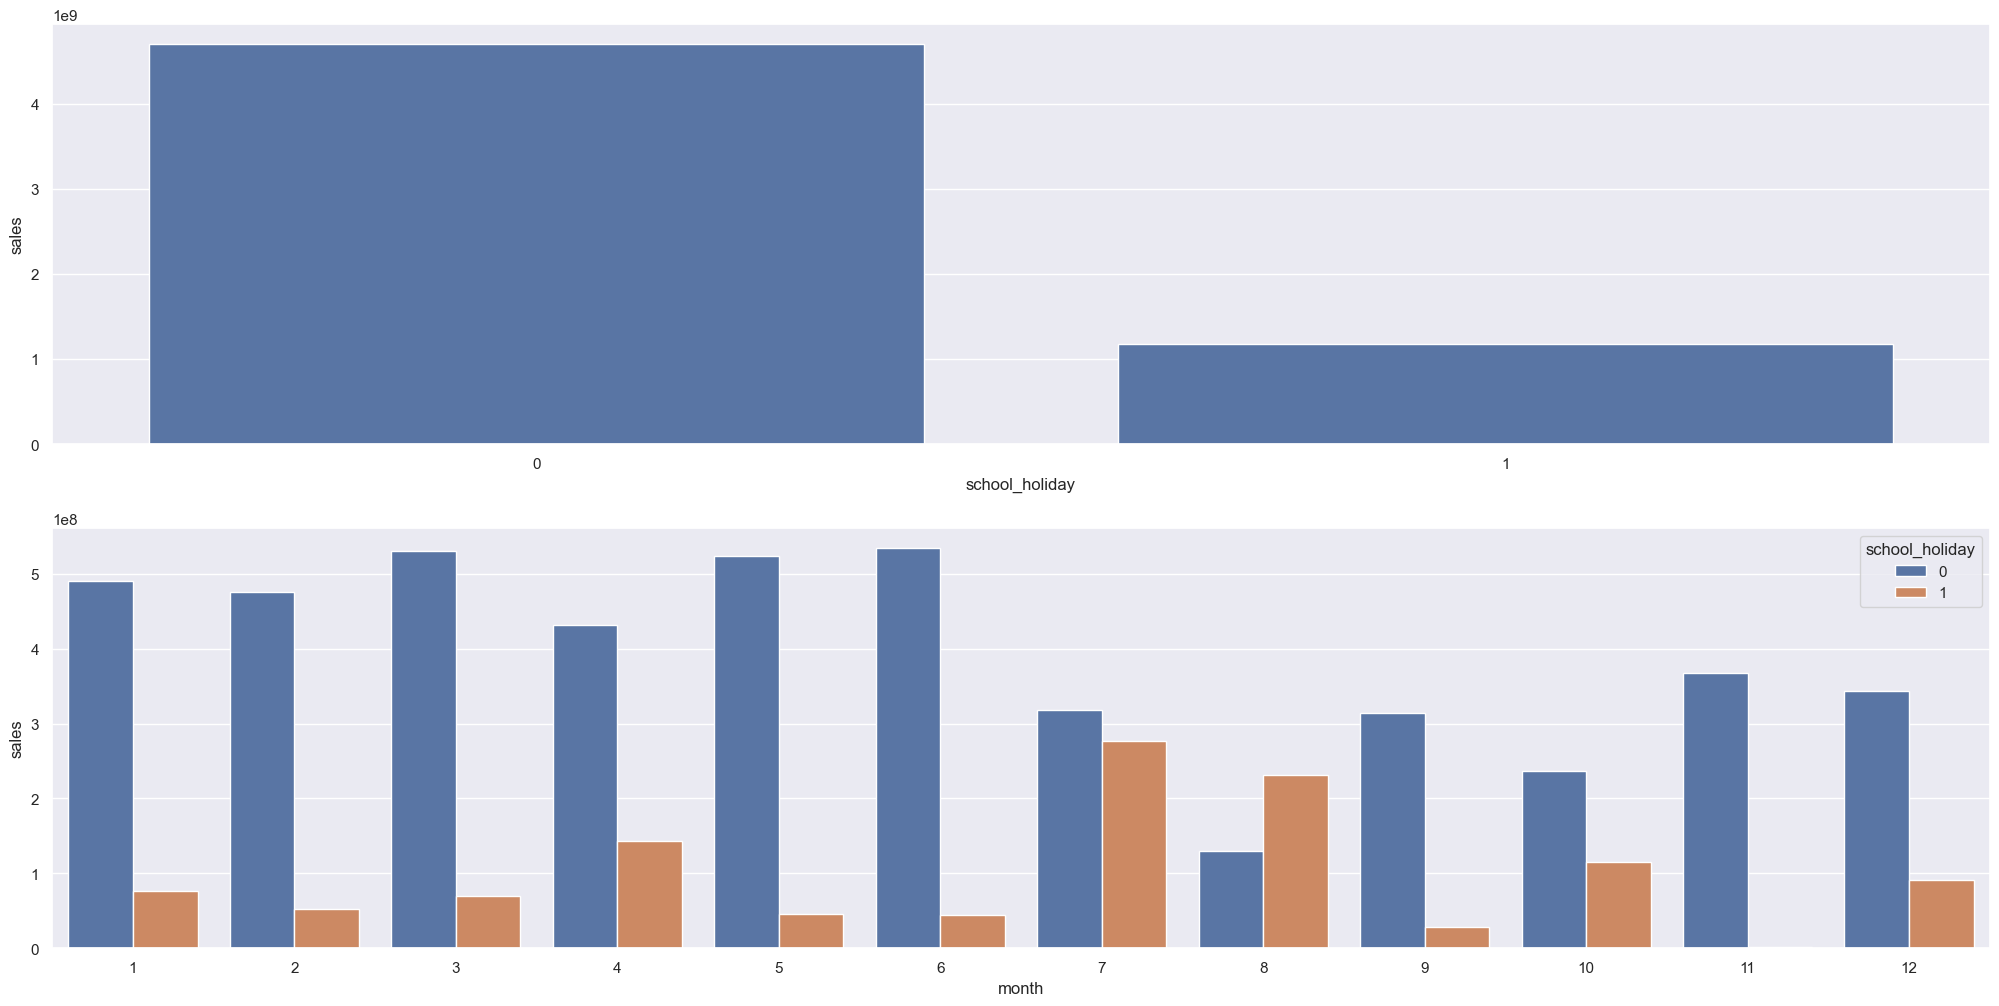

In [65]:
aux1 = df4[['school_holiday', 'sales']
           ].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );
aux2 = df4[['month', 'school_holiday', 'sales']
           ].groupby(['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );


### 4.2.1 Hypothesis Resume

In [70]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3. Multivariate Analysis 

### 4.3.1 Numerical Attributes 

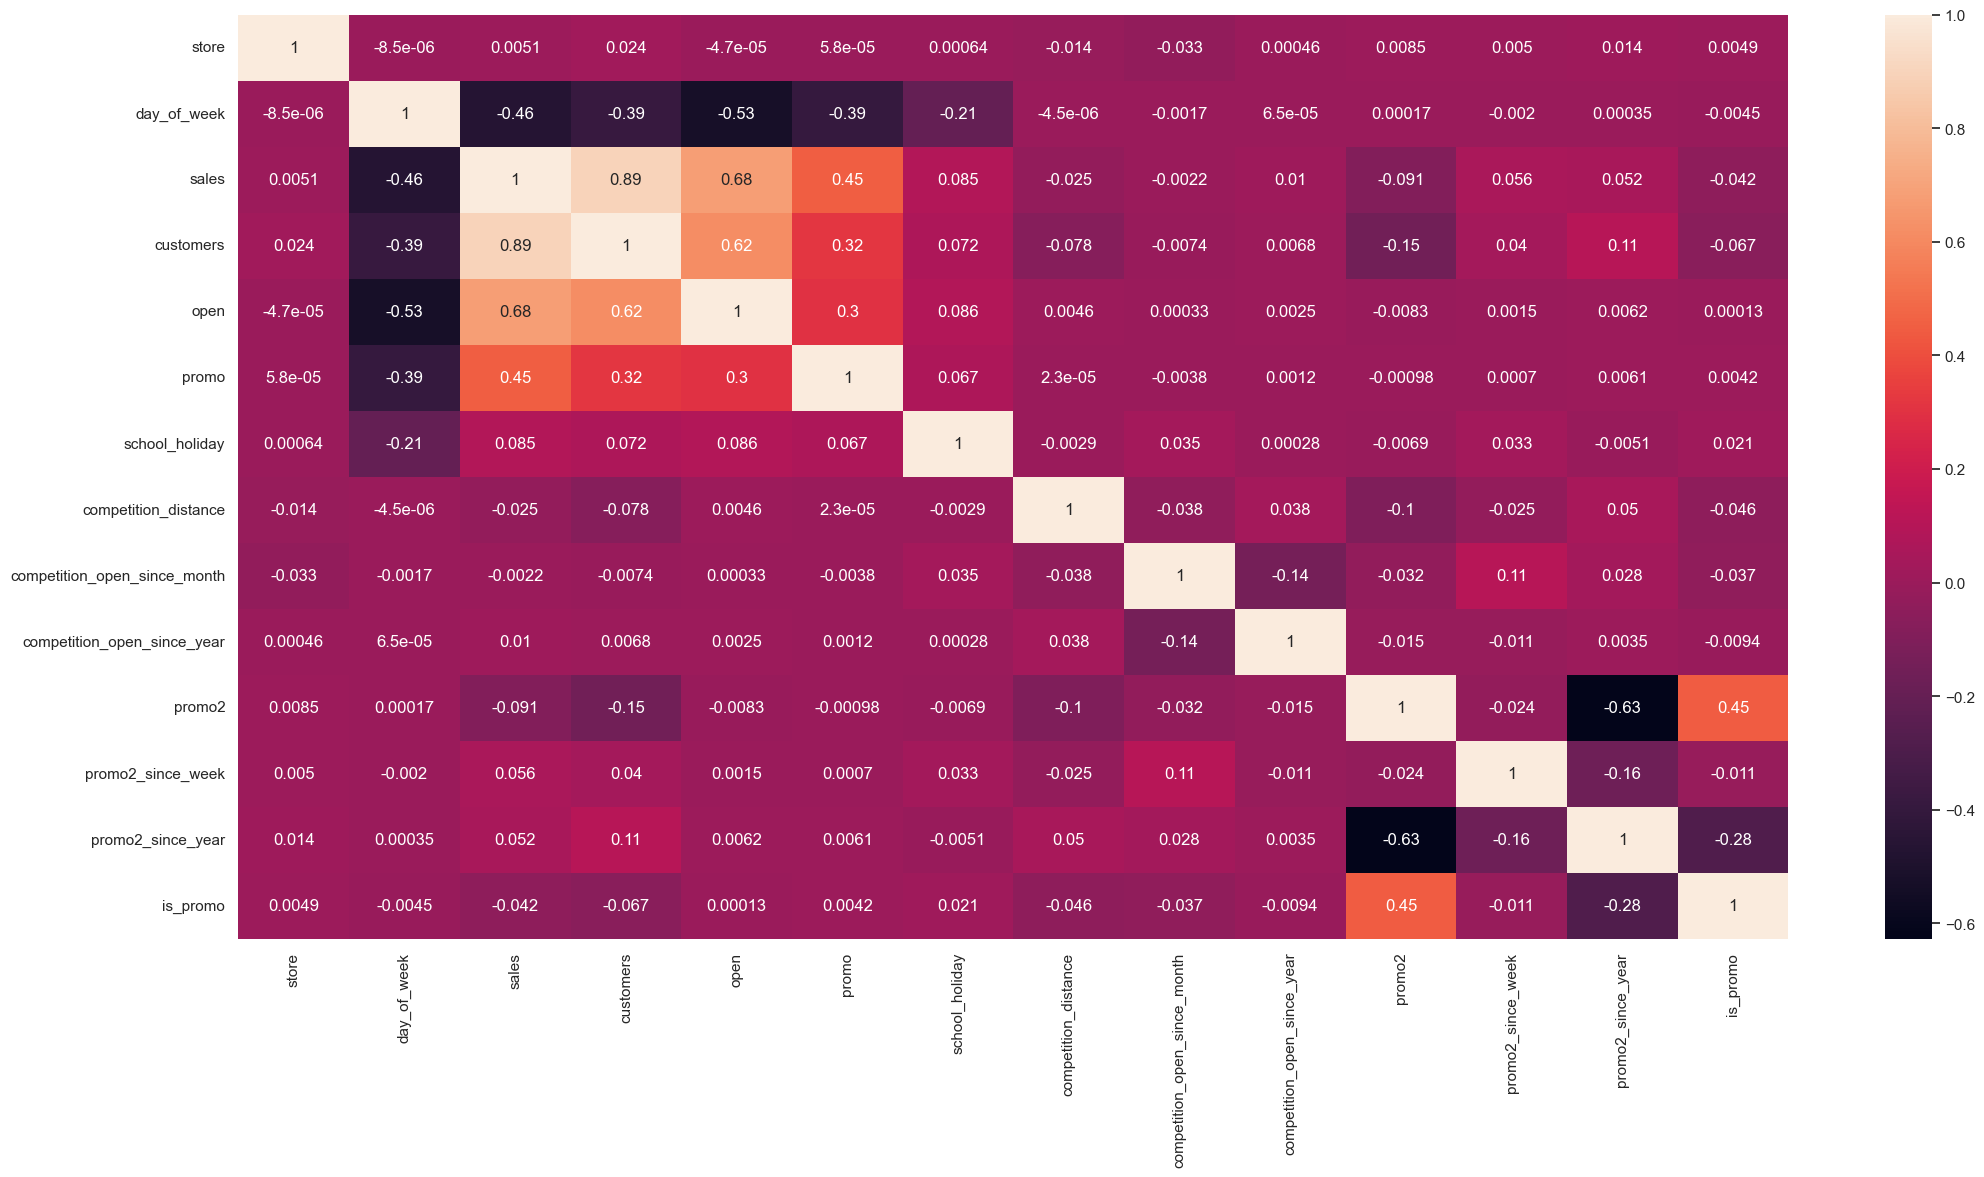

In [71]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2 Categorial Attributes 

<Axes: >

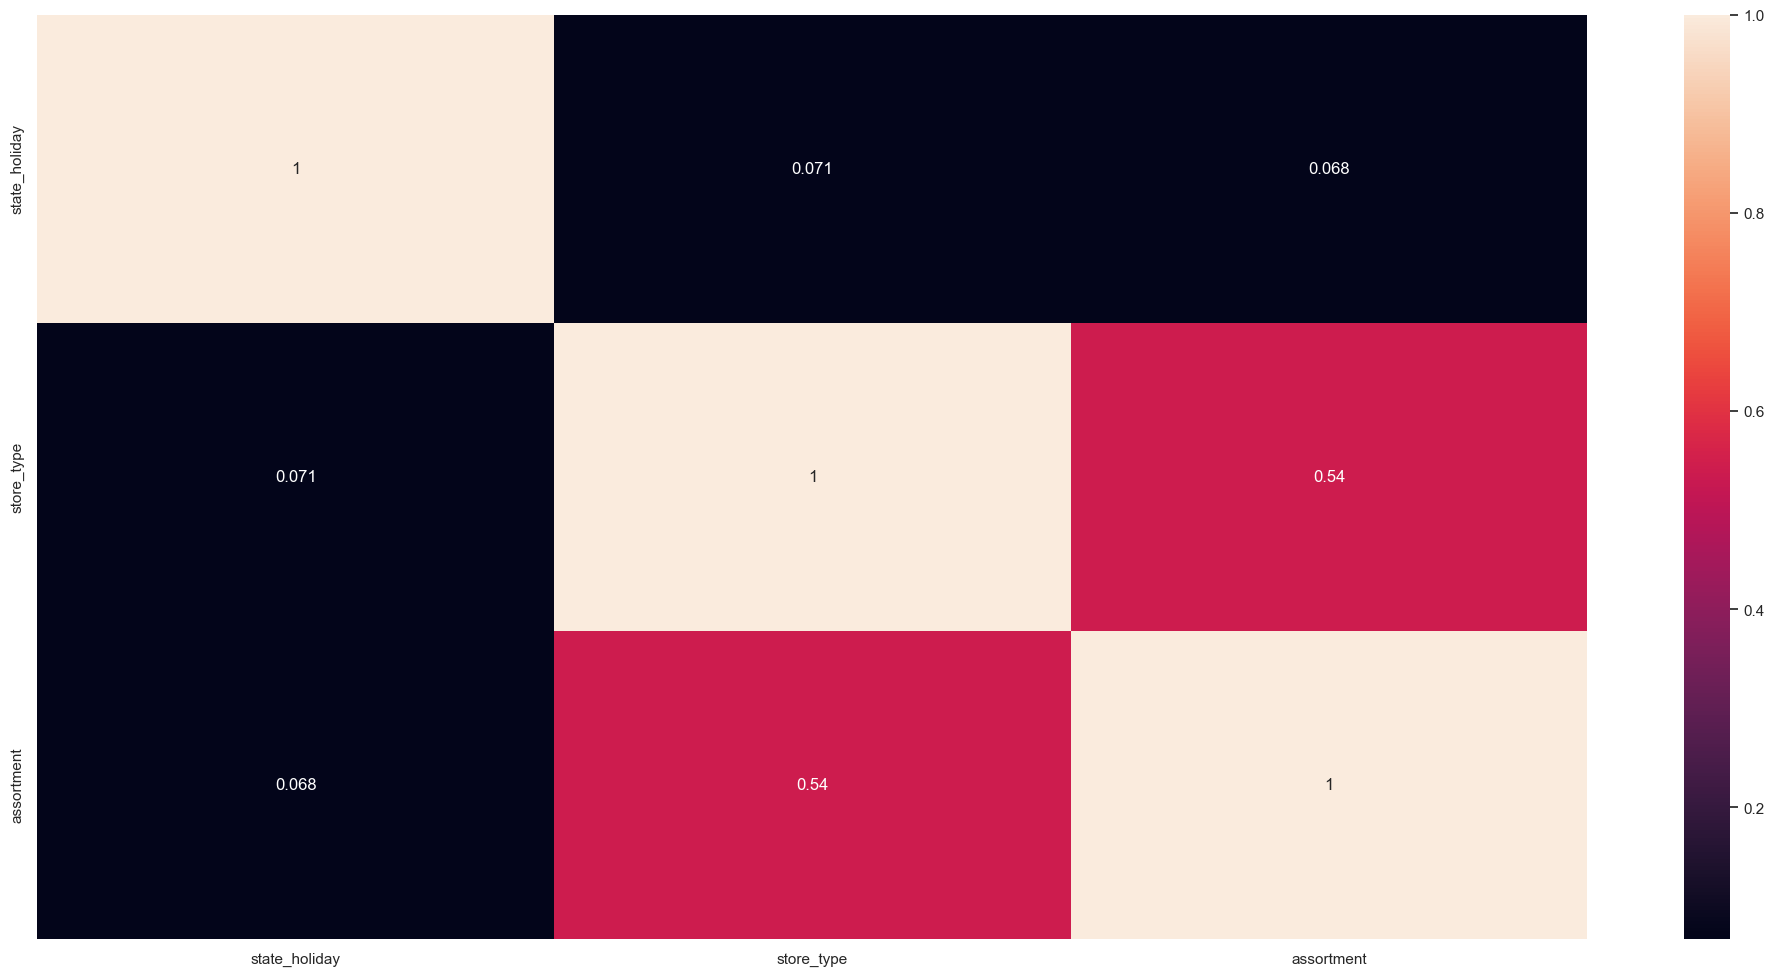

In [78]:
# only categorical data
a = df4.select_dtypes( include='object' )
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )
# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                    'store_type': [a4, a5, a6],
                    'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 5.0. DATA PREPARATION 

In [79]:
df5 = df4.copy()

## 5.1. Rescalling

In [80]:
rs = RobustScaler()
mms = MinMaxScaler()

